In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from tqdm import tqdm
import seaborn as sns
import sys
sys.path.append("../")
import util
import importlib
importlib.reload(util)

from util import util_functions
from util.util_functions import PreprocessInfo
from util.util_functions import ClusteringExperiment

px = 1/plt.rcParams["figure.dpi"]
plt.rcParams['figure.figsize'] = [1848*px, 965*px]
c = ["#007fff", "#ff3616", "#138d75", "#7d3c98", "#fbea6a"]  # Blue, Red, Green, Purple, Yellow

sns.set(
    style="ticks",
    rc={
        "font.family": "Arial",
        "font.size": 40,
        "axes.linewidth": 2,
        "lines.linewidth": 5,
    },
    font_scale=2.5,
    palette=sns.color_palette("Set2")
)
CONDUCTANCE_LABEL = r"Conductance (log$_{10}$(G/G$_0$))"
ALPHABET = "ABCDEFGHIJKLMNOPQ"
RNG_STATE = 42
FONTSIZE = 48

In [2]:
# blank_traces = np.load("./blanks.npz", allow_pickle=True)["conductance"]
blank_traces = np.load("./blanks_all_traces.npy", allow_pickle=True)
# molecular_traces = np.load("./molecular.npz", allow_pickle=True)["conductance"]
molecular_traces = np.load("./all_traces.npy", allow_pickle=True)

In [3]:
pre_info = PreprocessInfo(
    high=-1.0,
    low=-5.0,
    plot_high=-.5,
    plot_low=-5,
    bins=128,
    bins_2d=(64, 64),
    hist2d_length=1024,
)

In [12]:
# fullwindow_blanks, p_blanks = util_functions.rt_preprocessing(blank_traces[:len(blank_traces) // 3 + 256], pre_info, longest_cutoff=6_000, apply_log=False)
fullwindow_blanks, p_blanks = util_functions.rt_preprocessing(blank_traces[:len(blank_traces) // 2 + 1024*2], pre_info, longest_cutoff=6_000, apply_log=False)
fullwindow_molecular, p_molecular = util_functions.rt_preprocessing(molecular_traces[::1], pre_info, longest_cutoff=6_000, apply_log=False)

hist_blanks, hist_blanks2d = util_functions.get_histograms(
    p_blanks, low=pre_info.low, high=pre_info.high, pre_info=pre_info
)
hist_molecular, hist_molecular2d = util_functions.get_histograms(
    p_molecular, low=pre_info.low, high=pre_info.high, pre_info=pre_info
)

plot_hist_blanks, plot_hist_blanks2d = util_functions.get_histograms(
    p_blanks, low=pre_info.plot_low, high=pre_info.plot_high, pre_info=pre_info
)
plot_hist_molecular, plot_hist_molecular2d = util_functions.get_histograms(
    p_molecular, low=pre_info.plot_low, high=pre_info.plot_high, pre_info=pre_info
)

# ef_blanks = util_functions.extra_features(p_blanks)
# ef_molecular = util_functions.extra_features(p_molecular)

100%|██████████| 12010/12010 [00:00<00:00, 18861.64it/s]


Amount discarded: 0


100%|██████████| 24895/24895 [00:02<00:00, 12251.90it/s]


Amount discarded: 1430


Generating 1D- and 2D histograms: 100%|██████████| 23465/23465 [00:14<00:00, 1621.19it/s]


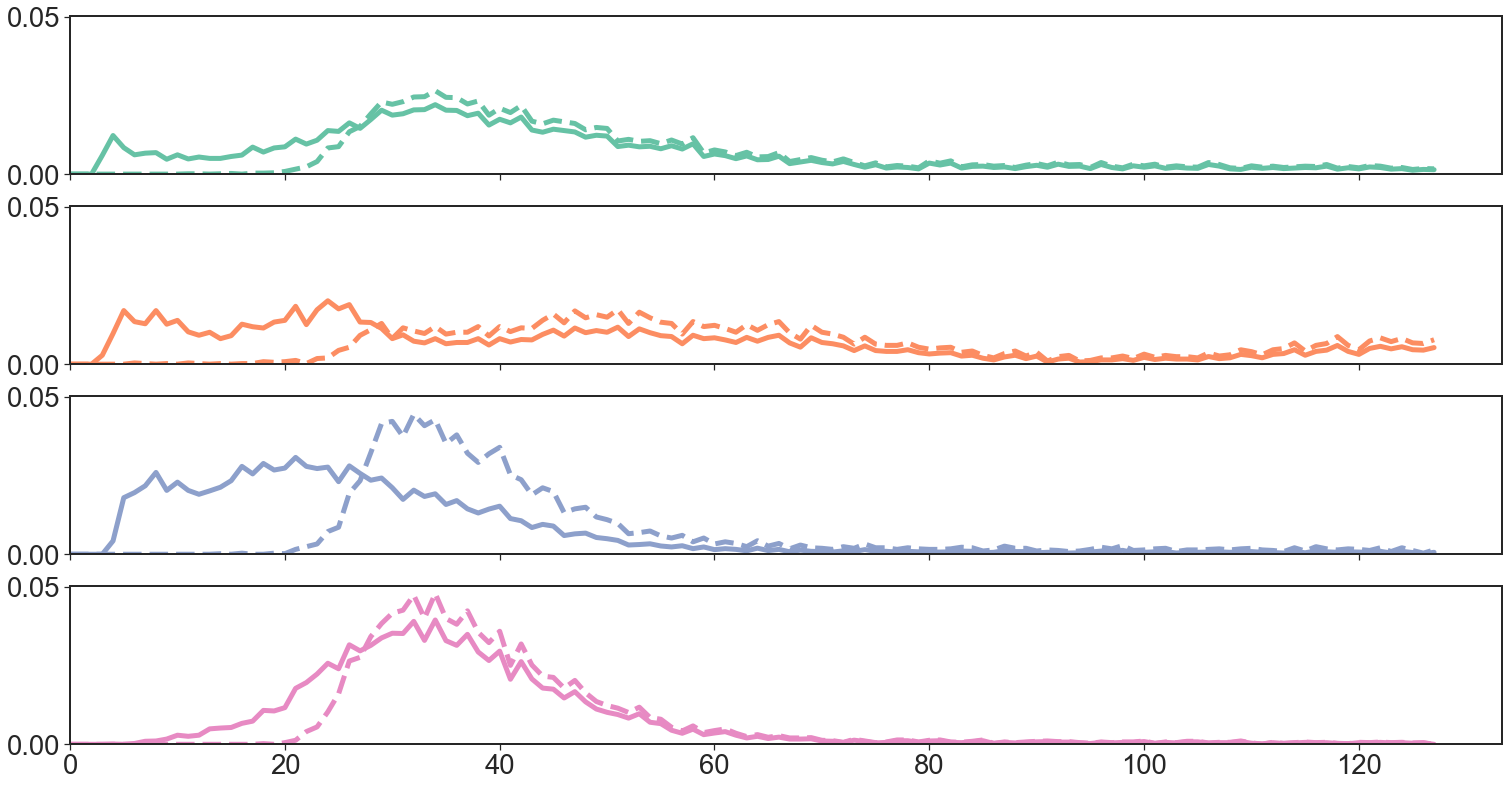

In [9]:
cluster_model = 3
len_bins = 128
len_range = (0, 1200)
set2 = sns.color_palette("Set2", 12)
fig, axes = plt.subplots(len(np.unique(cluster_labels[cluster_model])), 1, sharex=True, sharey=True)
for idx, l in enumerate(np.unique(cluster_labels[cluster_model])):
    og_lengths = np.histogram(
        [len(x) for x in p_molecular[cluster_labels[cluster_model] == l]],
        bins=len_bins,
        range=len_range,
    )[0]
    filtered_lengths = np.histogram(
        [len(x) for x in p_molecular[(cluster_labels[cluster_model] == l) & (filtered_labels[1] == -1)]],
        bins=len_bins,
        range=len_range,
    )[0]

    axes[idx].plot(filtered_lengths/len(p_molecular[(cluster_labels[cluster_model] == l) & (filtered_labels[1] == -1)]), linestyle="--", c=set2[idx])
    axes[idx].plot(og_lengths/len(p_molecular[cluster_labels[cluster_model] == l]), c=set2[idx])

axes[-1].set_xlim(0)
axes[-1].set_ylim(0)
plt.show()

In [82]:
H1 = generate_2d(p_molecular[filtered_labels[1] == 1])
H2 = generate_2d(p_molecular[filtered_labels[1] == -1])
H3 = generate_2d(p_blanks)

100%|██████████| 1577/1577 [00:00<00:00, 2223.83it/s]


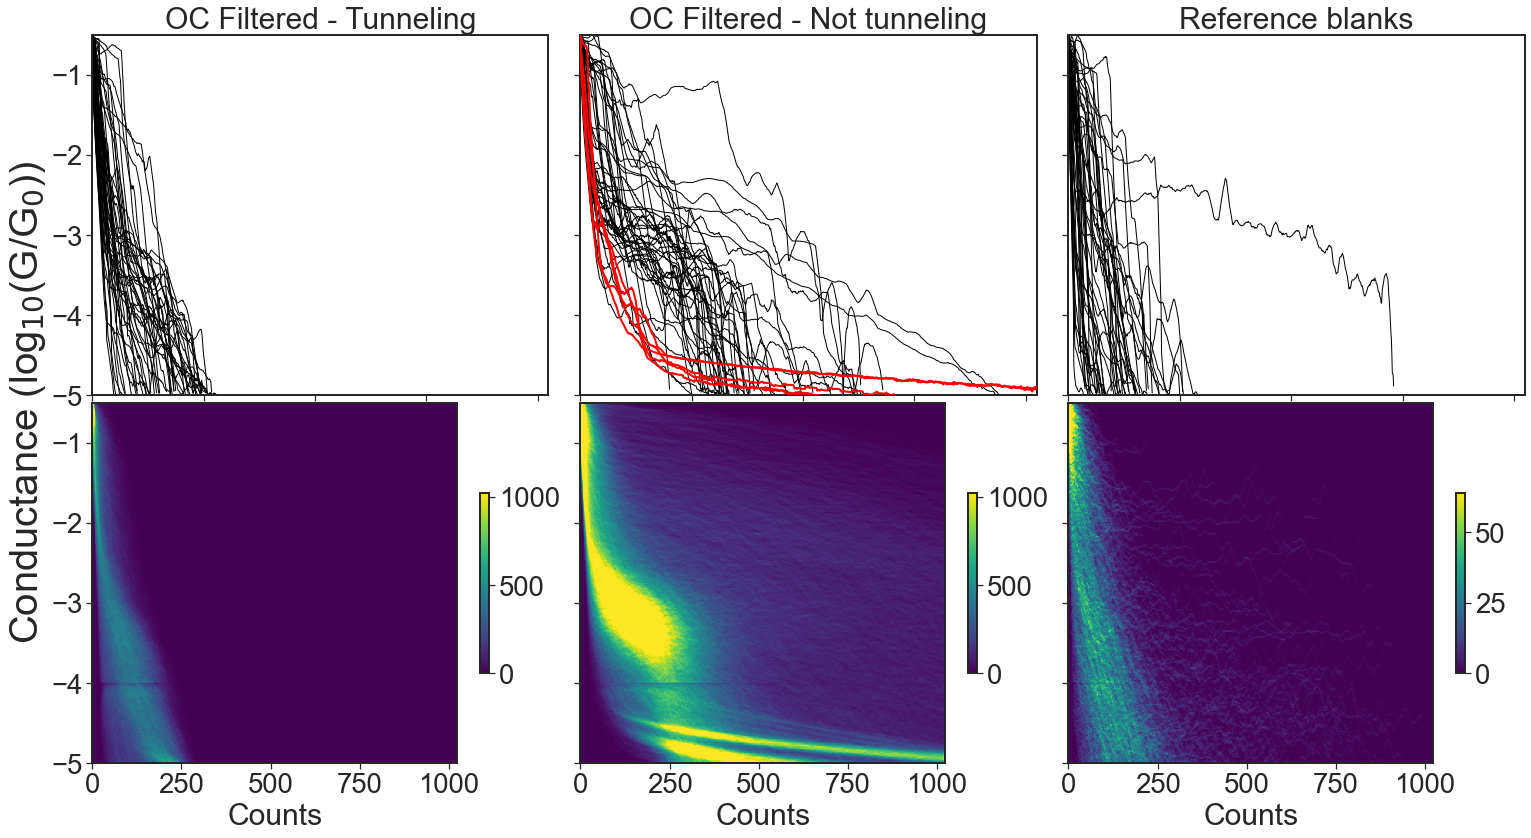

In [117]:
def plot_individual_traces(traces, amount: int, ax):
    for t in traces[200:200 + amount]:
        c = "k"
        linewidth = 1
        zorder = 1
        if np.mean(t) < -4.2 and len(t) > 512:
            c = "r"
            linewidth = 2
            zorder = 100
        ax.plot(t, linewidth=linewidth, c=c, zorder=zorder)

fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)
amount = 48
plot_individual_traces(p_molecular[filtered_labels[1] == 1], amount=amount, ax=ax[0, 0])
plot_individual_traces(p_molecular[filtered_labels[1] == -1], amount=amount, ax=ax[0, 1])
plot_individual_traces(p_blanks, amount=amount, ax=ax[0, 2])
im = ax[1, 0].imshow(H1, origin="lower", cmap="viridis", extent=[0, 1024, pre_info.low, pre_info.high], aspect="auto", vmin=0, vmax=1024)
fig.colorbar(im, ax=ax[1, 0], shrink=0.5)
im = ax[1, 1].imshow(H2, origin="lower", cmap="viridis", extent=[0, 1024, pre_info.low, pre_info.high], aspect="auto", vmin=0, vmax=1024)
fig.colorbar(im, ax=ax[1, 1], shrink=0.5)
im = ax[1, 2].imshow(H3, origin="lower", cmap="viridis", extent=[0, 1024, pre_info.low, pre_info.high], aspect="auto", vmin=0, vmax=64)
fig.colorbar(im, ax=ax[1, 2], shrink=0.5)

ax[0, 0].set_title("OC Filtered - Tunneling")
ax[0, 1].set_title("OC Filtered - Not tunneling")
ax[0, 2].set_title("Reference blanks")
fig.subplots_adjust(hspace=0.02, wspace=0.07)

for a in ax[1, :]:
    a.set_xlabel("Counts")
fig.text(0.09, 0.5, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical")
plt.show()

100%|██████████| 23465/23465 [00:13<00:00, 1768.38it/s]


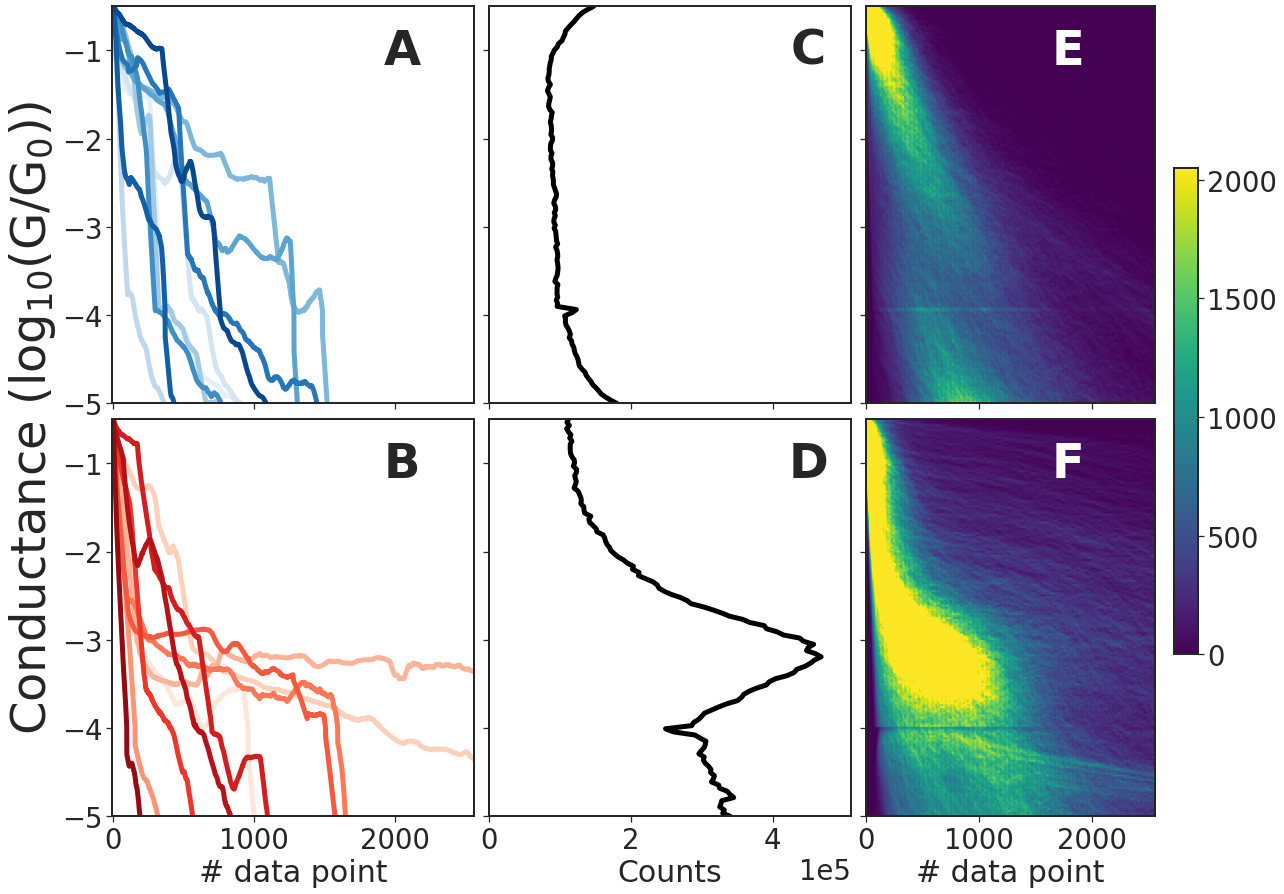

In [17]:
rng = np.random.default_rng(seed=RNG_STATE)
text_height = -1.
amount_traces = 10
blues = sns.color_palette("Blues", amount_traces)
reds = sns.color_palette("Reds", amount_traces)
colors = [blues, reds]

plot_length = 2048 + 512

# Visualization of both parts of the data set
fig, ax = plt.subplots(2, 3, figsize=(20, 30))
for idx, (dataset_hists, dataset_traces) in enumerate(
    [
        [plot_hist_blanks, p_blanks],
        [plot_hist_molecular, p_molecular],
    ]
):
    max_length = 0
    for c_i, trace in enumerate(dataset_traces[rng.integers(low=0, high=len(dataset_traces), size=amount_traces, endpoint=True)]):
        ax[idx, 0].plot(trace, c=colors[idx][c_i])
        if len(trace) > max_length:
            max_length = len(trace)
    ax[idx, 0].set_ylim(pre_info.plot_low, pre_info.plot_high)
    ax[idx, 0].set_xlim(-10, plot_length)
    ax[idx, 0].text(1024*2, text_height, ALPHABET[idx], va="center", ha="center", weight="bold", size=FONTSIZE)
    
    plot_hists = dataset_hists.sum(axis=0)
    ax[idx, 1].plot(
        plot_hists, np.linspace(pre_info.plot_low, pre_info.plot_high, dataset_hists.shape[1]), c="k"
    )
    ax[idx, 1].set_xlim(0, 5.1e5)
    ax[idx, 1].set_ylim(pre_info.plot_low, pre_info.plot_high)
    ax[idx, 1].text(4.5e5, text_height, ALPHABET[idx + 2], va="center", ha="center", weight="bold", size=FONTSIZE)

    bins_2d = 128 + 64
    hist_2d = np.zeros((bins_2d, bins_2d))
    for trace in tqdm(dataset_traces):
        H, *_ = np.histogram2d(
            trace, np.arange(len(trace)), bins=bins_2d, range=[[pre_info.plot_low, pre_info.plot_high], [0, plot_length]]
        )
        hist_2d += H

    vmax = 2048
    im = ax[idx, 2].imshow(
        hist_2d, vmin=0, vmax=vmax, origin="lower", cmap="viridis", extent=[0, plot_length, pre_info.plot_low, pre_info.plot_high], aspect="auto"
    )
    ax[idx, 2].text(
        2048 - 256, text_height, ALPHABET[idx + 4], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    )
    # fig.colorbar(im, ax=ax[idx, 2], shrink=.9)

    if idx == 0:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
        ax[idx, 2].set_xticklabels([])

    ax[idx, 1].set_yticklabels([])
    ax[idx, 2].set_yticklabels([])
    if idx == 1:
        ax[idx, 0].set_xlabel("# data point")
        ax[idx, 1].set_xlabel("Counts")
        ax[idx, 2].set_xlabel("# data point")
        ax[idx, 1].ticklabel_format(axis="x", scilimits=[-5, 4])

fig.text(0.07, 0.31, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)
fig.subplots_adjust(wspace=0.04, top=0.5, hspace=0.04)
fig.colorbar(im, ax=ax[:, 2], shrink=.6)
fig.savefig("hists.pdf")
plt.show()

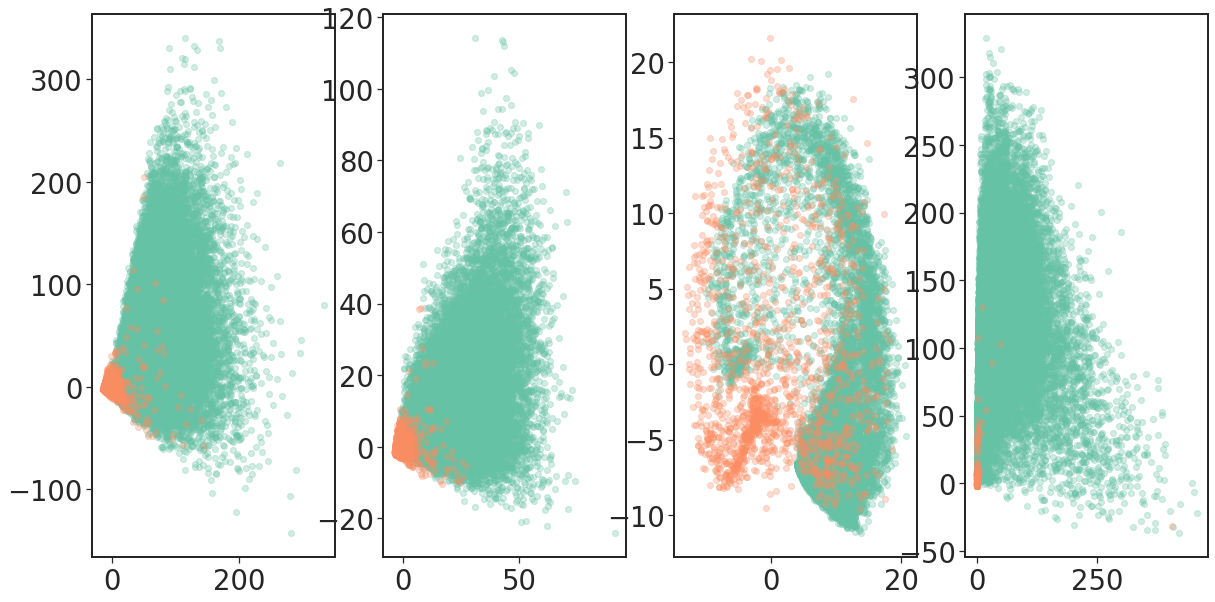

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)

fig, ax = plt.subplots(1, 4, figsize=(20, 10))
for idx, features in enumerate([[hist_blanks, hist_molecular], [hist_blanks2d, hist_molecular2d]]):
    trans = pca.fit_transform(features[0])
    trans_mol = pca.transform(features[1])
    ax[idx*2].scatter(trans_mol[:, 0], trans_mol[:, 1], alpha=0.3)
    ax[idx*2].scatter(trans[:, 0], trans[:, 1], alpha=0.3)

    scaler = StandardScaler()
    trans = pca.fit_transform(scaler.fit_transform(features[0]))
    trans_mol = pca.transform(scaler.transform(features[1]))
    ax[idx*2 + 1].scatter(trans_mol[:, 0], trans_mol[:, 1], alpha=0.3)
    ax[idx*2 + 1].scatter(trans[:, 0], trans[:, 1], alpha=.3)

## SIMCA modeling
Soft Independent Modeling of Class Analogy

Train mean: 7.53e-14
Train std: 88.68
Test mean: -20.21
Test std: 111.0


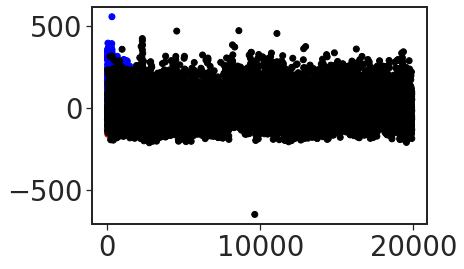

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
train = scaler.fit_transform(hist_blanks2d[:-32])
test = scaler.transform(hist_blanks2d[-32:])
molecular_test = scaler.transform(hist_molecular2d[:1600])

pca = PCA(n_components=8)
trans = pca.fit_transform(train)

train_residuals = (train - pca.inverse_transform(trans)).sum(axis=1)
plt.scatter(range(len(train_residuals)), train_residuals, c=["k"]*len(train), zorder=10)

print(f"Train mean: {np.mean(train_residuals):.4}")
print(f"Train std: {np.std(train_residuals):.4}")

test_residuals = (test - pca.inverse_transform(pca.transform(test))).sum(axis=1)
plt.scatter(range(len(test_residuals)), test_residuals, c=["r"]*len(test))

print(f"Test mean: {np.mean(test_residuals):.4}")
print(f"Test std: {np.std(test_residuals):.4}")

molecular_test_residuals = (
    molecular_test - pca.inverse_transform(pca.transform(molecular_test))
).sum(axis=1)
plt.scatter(
    range(len(molecular_test_residuals)),
    molecular_test_residuals,
    c=["b"]*len(molecular_test)
)
plt.show()

In [109]:
print(hist_blanks2d.shape)
print(train.shape)

(1456, 4096)
(1424, 4096)


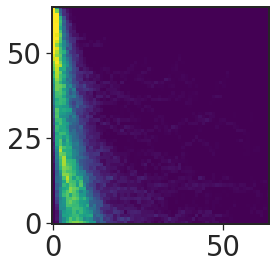

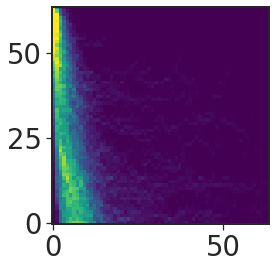

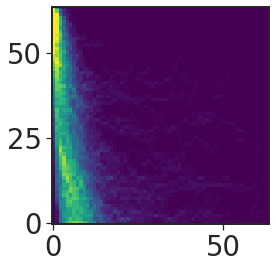

In [111]:
vmax = 512
plt.imshow(hist_blanks2d.reshape((1456, 64, 64)).sum(axis=0), origin="lower", vmin=0, vmax=vmax, cmap="viridis")
plt.show()

plt.imshow(scaler.inverse_transform(pca.inverse_transform(trans)).reshape((1424, 64, 64)).sum(axis=0), origin="lower", vmin=0, vmax=vmax, cmap="viridis")
plt.show()
plt.imshow(scaler.inverse_transform(train).reshape((1424, 64, 64)).sum(axis=0), origin="lower", vmin=0, vmax=vmax, cmap="viridis")
plt.show()

Decision threshold: 334.7529667017633


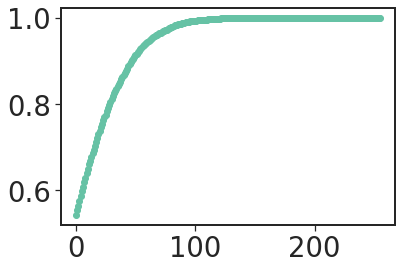

In [12]:
def get_closest(array, value):
    idx = np.abs(array - value).argmin()
    return array[idx], idx

predicted_percent = []
decision_thresholds = np.linspace(
    np.min(np.abs(train_residuals)), np.max(np.abs(train_residuals)), 256
)
for thresh in decision_thresholds:
    above_thresh = len(train_residuals[train_residuals > thresh])
    predicted_percent.append(1 - above_thresh/len(train_residuals))

val, idx = get_closest(np.array(predicted_percent), 0.999)
print(f"Decision threshold: {decision_thresholds[idx]}")
plt.scatter(range(len(predicted_percent)), predicted_percent)
plt.show()

In [28]:
from scipy import stats

E = train - pca.inverse_transform(trans)
residual_variance_x = np.sum(E**2, axis=1)
b = np.mean(residual_variance_x)
v = np.var(residual_variance_x)
chi_square = stats.chi2.ppf(q=0.9, df=(2*b**2)/v)
spe_ucl = (v/(2*b))*chi_square

print(spe_ucl)

2407.5383501433616


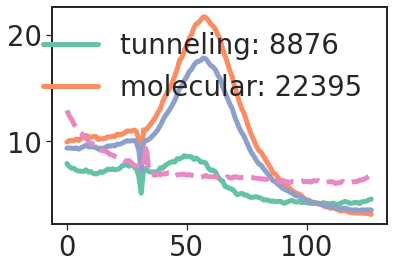

In [15]:
amount = 4096*12
molecular_scores = pca.transform(scaler.transform(hist_molecular2d[:amount]))
molecular_residuals = (
    scaler.transform(hist_molecular2d[:amount]) 
    - pca.inverse_transform(molecular_scores)
).sum(axis=1)

labels = np.array([1 if np.abs(x) > 60 else 0 for x in molecular_residuals])

# T = trans
# B = T.T @ T/(train.shape[0] - 1)
# inv_B = np.linalg.inv(B)
# labels = np.array([1 if np.abs(x.T @ inv_B @ x) > 0.02 else 0 for x in molecular_scores])

pred_tun = hist_molecular[:amount][labels == 0]
pred_mol = hist_molecular[:amount][labels == 1]
plt.plot(pred_tun.sum(axis=0)/len(pred_tun), label=f"tunneling: {len(pred_tun)}")
plt.plot(pred_mol.sum(axis=0)/len(pred_mol), label=f"molecular: {len(pred_mol)}")

plt.plot(hist_molecular[:amount].sum(axis=0)/len(hist_molecular[:amount]))
plt.plot(hist_blanks.sum(axis=0)/len(hist_blanks), linestyle="--")
plt.legend(frameon=False)
plt.show()

NameError: name 'BINS' is not defined

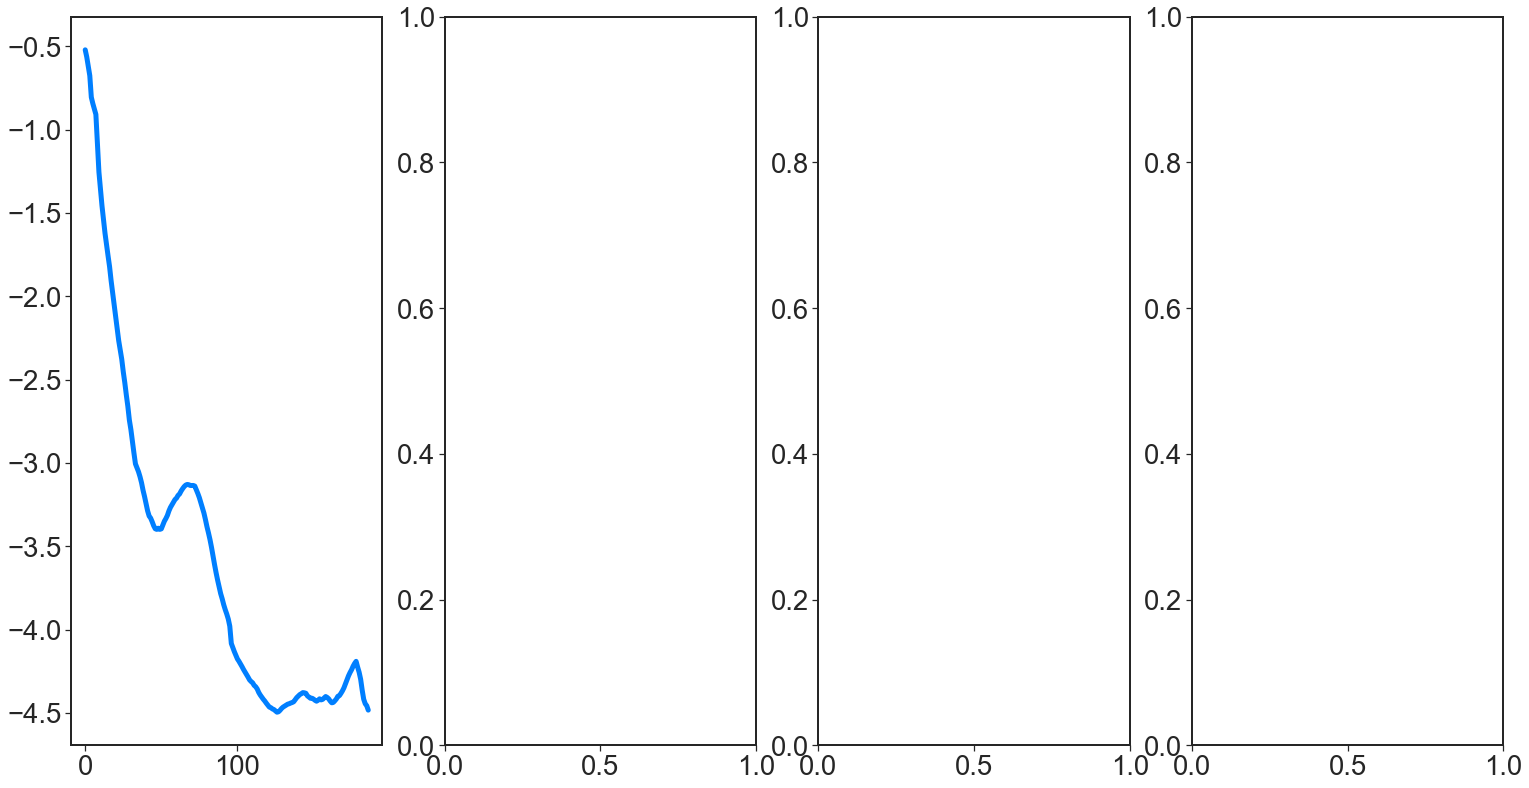

In [14]:
fig, ax = plt.subplots(1, 4)
for t in p_molecular[labels == 0][np.random.randint(0, len(labels[labels == 0]), size=1)]:
    ax[0].plot(t, c=c[0])
    hist, binedges = np.histogram(t, bins=BINS, range=(LOW, HIGH))
    binedges = (binedges[1:] + binedges[:-1])/2
    ax[1].plot(hist, binedges, c=c[0])
    
    ax[0].set_ylim(np.min(t), np.max(t))
    ax[1].set_ylim(np.min(t), np.max(t))

for t in p_molecular[labels == 1][np.random.randint(0, len(labels[labels == 1]), size=1)]:
    ax[2].plot(t, c=c[1])
    hist, binedges = np.histogram(t, bins=BINS, range=(LOW, HIGH))
    binedges = (binedges[1:] + binedges[:-1])/2
    ax[3].plot(hist, binedges, c=c[1])
    
    ax[2].set_ylim(np.min(t), np.max(t))
    ax[3].set_ylim(np.min(t), np.max(t))
plt.show()

In [18]:
from sklearn.svm import OneClassSVM
# from sklearn.ensemble import IsolationForest
from sklego.mixture import GMMOutlierDetector
# from pyod.models.auto_encoder import AutoEncoder
# from pyod.models.deep_svdd import DeepSVDD
# from pyod.models.vae import VAE
from sklearn.metrics import pairwise

# model_ocsvm_rbf = OneClassSVM(kernel="rbf", nu=0.01, gamma=2e-2)
model_ocsvm_rbf = OneClassSVM(kernel="rbf", nu=0.01, gamma="scale")
model_ocsvm_linear = OneClassSVM(kernel="linear", nu=0.01, gamma="scale")
# model_ocsvm_laplac = OneClassSVM(kernel=pairwise.laplacian_kernel, nu=0.01, gamma=3e-5)
# model_iso = IsolationForest(contamination=0.001)
model_gmm_1comp = GMMOutlierDetector(n_components=1, threshold=0.99, random_state=RNG_STATE)
model_gmm_3comp = GMMOutlierDetector(n_components=3, threshold=0.99, random_state=RNG_STATE)
model_gmm_4comp = GMMOutlierDetector(n_components=4, threshold=0.99, random_state=RNG_STATE)
# model_gmm_5comp = GMMOutlierDetector(n_components=5, threshold=0.99, random_state=RNG_STATE)
model_gmm_6comp = GMMOutlierDetector(n_components=6, threshold=0.99, random_state=RNG_STATE)
# model_gmm_9comp = GMMOutlierDetector(n_components=9, threshold=0.99, random_state=RNG_STATE)

# deep learning models
epochs = 16
# model_simple_ae = AutoEncoder(epochs=epochs, hidden_activation="relu", contamination=0.1, random_state=RNG_STATE)
# model_deepsvdd_ae = DeepSVDD(use_ae=True, epochs=epochs, hidden_activation="relu", contamination=0.1, random_state=RNG_STATE)
# model_deepsvdd_noae = DeepSVDD(use_ae=False, epochs=epochs, hidden_activation="relu", contamination=0.1, random_state=RNG_STATE)
# model_vae = VAE(epochs=epochs, gamma=0.8, hidden_activation="relu", contamination=0.1, random_state=RNG_STATE)

models = [
    model_ocsvm_linear,
    model_ocsvm_rbf,
    # # model_ocsvm_laplac,
    # # model_ocsvm_cheb,
    # # model_iso,
    model_gmm_1comp,
    model_gmm_3comp,
    model_gmm_4comp,
    # model_gmm_5comp,
    model_gmm_6comp,
    # model_gmm_9comp,
    # # model_gmm_8comp,
    # model_simple_ae,
    # model_deepsvdd_ae,
    # model_deepsvdd_noae,
    # model_vae,
]

In [19]:
# features_blanks = hist_blanks
# features_molecular = hist_molecular

features_blanks = hist_blanks2d
features_molecular = hist_molecular2d
# features_blanks[features_blanks == 0] = 1e-4
# features_molecular[features_molecular == 0] = 1e-4
# the DL models can't handle 0's in the features due to sigmoid activation function

# features_blanks = np.concatenate((hist_blanks2d, ef_blanks), axis=1)
# features_molecular = np.concatenate((hist_molecular2d, ef_molecular), axis=1)


# remove zero columns
# idx = np.argwhere(np.all(features_blanks[..., :] < 4, axis=0))

# a2 = np.delete(features_blanks, idx, axis=1)
# print(f"Sum of all BEFORE removal: {np.sum(features_blanks)}")
# print(f"Sum of all AFTER removal: {np.sum(a2)}")

# features_blanks = a2

# a2 = np.delete(features_molecular, idx, axis=1)
# print(f"Sum of all BEFORE removal: {np.sum(features_molecular)}")
# print(f"Sum of all AFTER removal: {np.sum(a2)}")
# features_molecular = a2

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# scaler = MinMaxScaler(feature_range=(1e-4, 1))
scaler = StandardScaler()
scaled_blanks = scaler.fit_transform(features_blanks)
scaled_molecular = scaler.transform(features_molecular)
predicted_labels = []
for model in tqdm(models):
    tmp_pca = PCA(n_components=256)
    model = model.fit(tmp_pca.fit_transform(scaled_blanks))

    pred_labels = model.predict(tmp_pca.transform(scaled_molecular))
    predicted_labels.append(pred_labels)

100%|██████████| 6/6 [02:39<00:00, 26.55s/it]


(1024, 256)


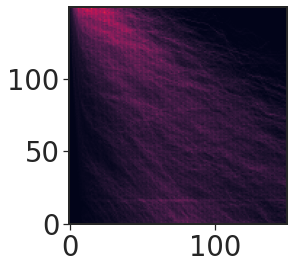

In [12]:
n_samples = 1024
sampled = models[-1].sample(n_samples=n_samples)
print(sampled[0].shape)

plt.imshow(scaler.inverse_transform(tmp_pca.inverse_transform(sampled[0])).reshape((n_samples, 150, 150)).sum(axis=0), origin="lower", vmin=0, vmax=n_samples//4)
plt.show()

# plt.plot(scaler.inverse_transform(sampled[0]).sum(axis=0)/n_samples)
# plt.plot(features_blanks.sum(axis=0)/len(features_blanks))

In [28]:
predicted_labels = np.load("./traditional_oc_labels.npy")
# predicted_labels = np.delete(predicted_labels, 5, axis=0)

In [21]:
print(predicted_labels.shape)

(6, 23465)


Amount predicted blanks: 8484


Generating 2D histograms: 100%|██████████| 8484/8484 [00:04<00:00, 1718.85it/s]


Amount predicted blanks: 9356


Generating 2D histograms: 100%|██████████| 9356/9356 [00:04<00:00, 1954.09it/s]


Amount predicted blanks: 21893


Generating 2D histograms: 100%|██████████| 21893/21893 [00:12<00:00, 1729.84it/s]


Amount predicted blanks: 12412


Generating 2D histograms: 100%|██████████| 12412/12412 [00:06<00:00, 1847.40it/s]


Amount predicted blanks: 7156


Generating 2D histograms: 100%|██████████| 7156/7156 [00:03<00:00, 2261.75it/s]


Amount predicted blanks: 3559


Generating 2D histograms: 100%|██████████| 3559/3559 [00:01<00:00, 2134.47it/s]


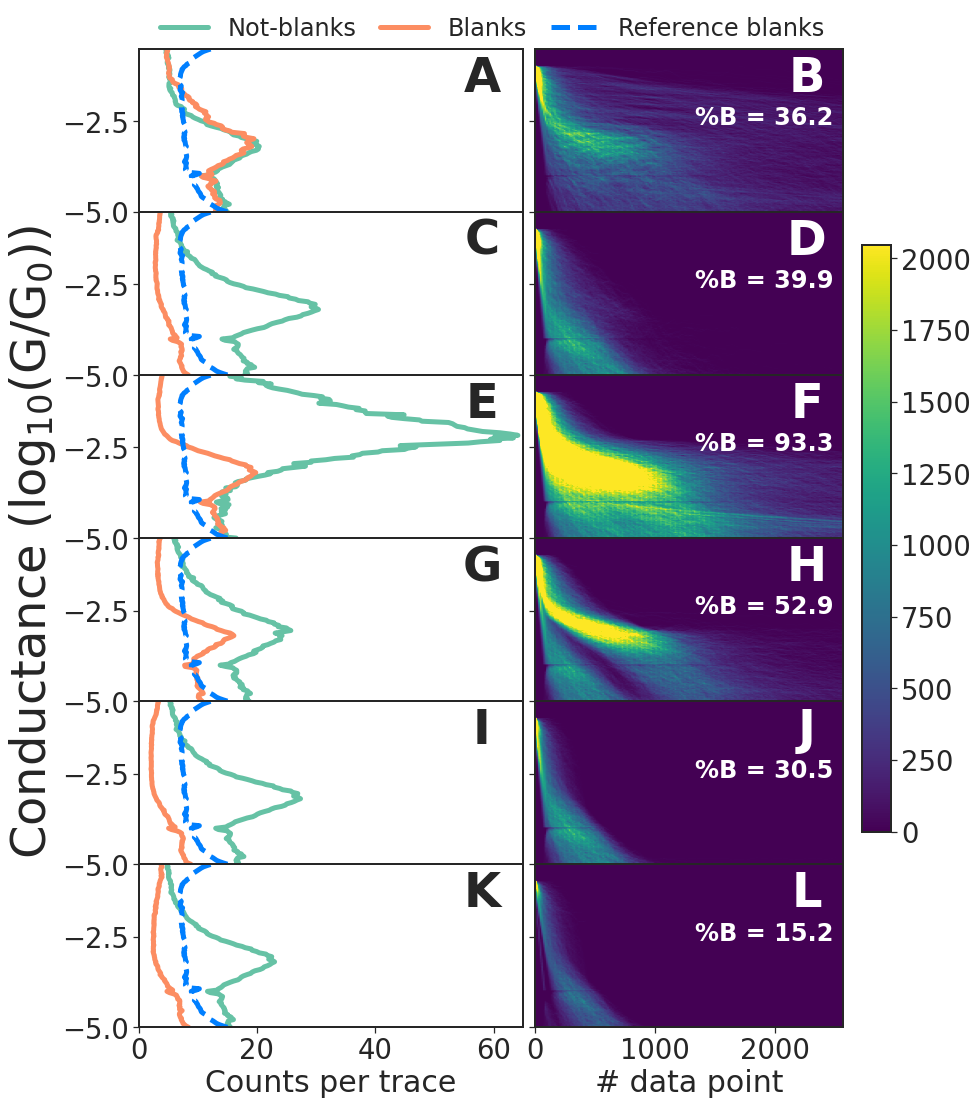

In [29]:
fig, ax = plt.subplots(len(models), 2, figsize=(14, 18))  # or 26
text_height = -1.3

ax1_yaxis = np.linspace(pre_info.plot_low, pre_info.plot_high, pre_info.bins)
max_ax1 = 0
percentages = []
for idx, (pred_labels, model) in enumerate(zip(predicted_labels, models)):
    if model.__class__.__name__ in ["AutoEncoder", "VAE", "DeepSVDD"]:
        pred_labels[pred_labels == 0] = -1
        pred_labels *= -1

    # linear ocsvm has switched the pred_labels
    if model.__class__.__name__ == "OneClassSVM":
        if model.get_params()["kernel"] == "linear":
            pred_labels *= -1

    pred_mol = plot_hist_molecular[pred_labels == -1]
    ax[idx, 0].plot(
        pred_mol.sum(axis=0)/len(pred_mol),
        ax1_yaxis,
        label=f"Not-blanks" if idx == 0 else ""
    )
    pred_tun = plot_hist_molecular[pred_labels == 1]
    ax[idx, 0].plot(
        pred_tun.sum(axis=0)/len(pred_tun),
        ax1_yaxis,
        label=f"Blanks" if idx == 0 else ""
    )
    print(f"Amount predicted blanks: {len(pred_tun)}")
    percentages.append(1.0 - (len(hist_molecular) - len(pred_tun))/len(hist_molecular))

    ax[idx, 0].plot(
        plot_hist_blanks.sum(axis=0)/len(plot_hist_blanks),
        ax1_yaxis,
        c=c[0],
        linestyle="--",
        label="Reference blanks" if idx == 0 else "",
    )

    bins_2d = 128 + 64
    hist_2d = np.zeros((bins_2d, bins_2d))
    for trace in tqdm(fullwindow_molecular[pred_labels == 1], desc="Generating 2D histograms"):
        H, *_ = np.histogram2d(
            trace, np.arange(len(trace)), bins=bins_2d, range=[[pre_info.plot_low, pre_info.plot_high], [0, plot_length]]
        )
        hist_2d += H

    im = ax[idx, 1].imshow(
        hist_2d,
        vmin=0,
        vmax=2048,
        origin="lower",
        cmap="viridis",
        extent=[0, plot_length, pre_info.plot_low, pre_info.plot_high],
        aspect="auto",
    )
    ax[idx, 1].text(
        plot_length - 300, text_height, ALPHABET[idx*2 + 1], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    )
    
    if not idx == len(models) - 1:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
    ax[idx, 1].set_yticklabels([])
    ax[idx, 0].set_ylim(pre_info.plot_low, pre_info.plot_high)
ax[0, 0].legend(frameon=False, loc="lower left", bbox_to_anchor=(0.0, 0.92, 1, 0), ncol=3, columnspacing=1., fontsize=FONTSIZE//2)

for idx, p in enumerate(percentages):
    # ax[idx, 0].text(11.5e4, text_height, ALPHABET[idx], va="center", ha="center", fontsize=FONTSIZE, weight="bold")
    ax[idx, 0].text(58, text_height, ALPHABET[idx*2], va="center", ha="center", fontsize=FONTSIZE, weight="bold")
    ax[idx, 1].text(plot_length - 300 - 350, text_height - 1.1, f"%B = {p*100:.3}", va="center", ha="center", fontsize=FONTSIZE // 2, c="white", weight="bold")
    # ax[idx, 0].set_xlim(0, 12.5e4)
    ax[idx, 0].set_xlim(0, 65)

ax[-1, 0].set_xlabel("Counts per trace")
ax[-1, 1].set_xlabel("# data point")
# fig.text(0.5, 0.08, "# Data points", va="center", ha="center")
fig.text(0.02, 0.5, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)
fig.subplots_adjust(hspace=0.0, wspace=0.03)
fig.colorbar(im, ax=ax[:, 1], shrink=.6)
plt.savefig("./visual_perf.pdf")
plt.show()

## Plot length distribution

In [30]:
length_range = (0, 2048)
length_bins = 128

100%|██████████| 6/6 [00:00<00:00, 60.70it/s]


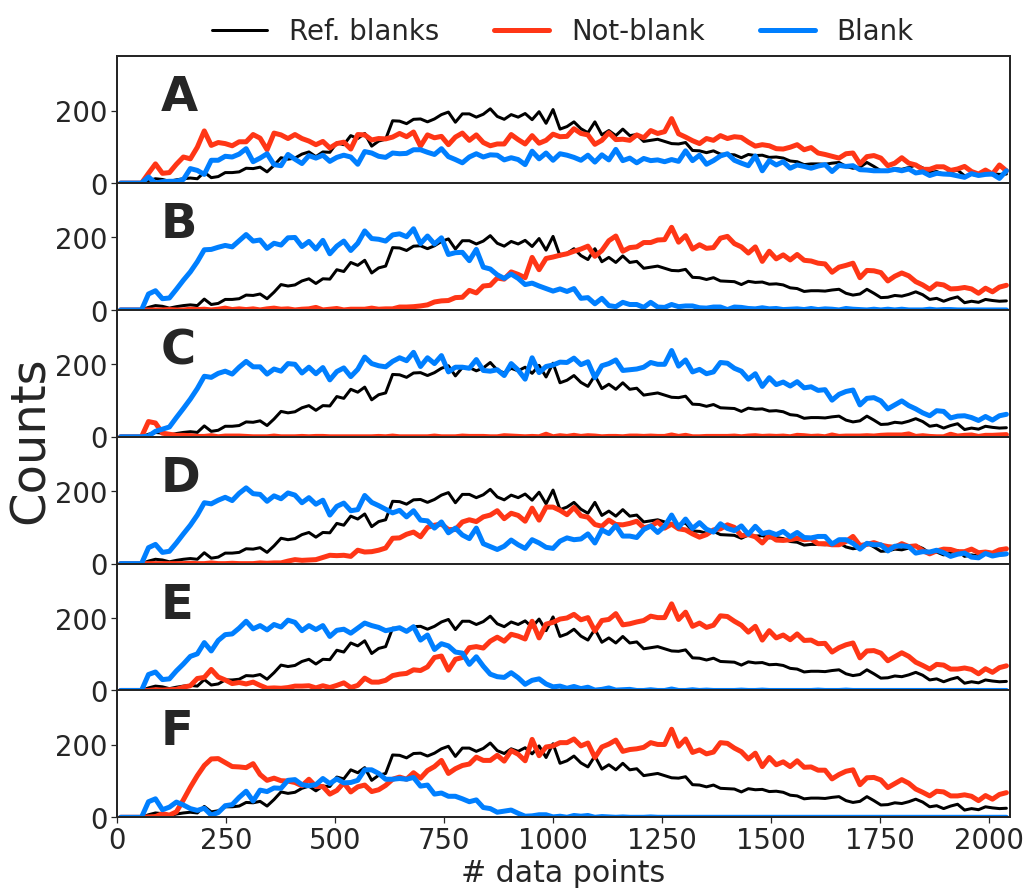

In [39]:
fig, ax = plt.subplots(len(models), 1, figsize=(16, 14), sharex=True, sharey=True)
pal = sns.color_palette("Set2", 12)
len_ref = np.histogram([len(x) for x in p_blanks], bins=length_bins, range=length_range)[0]
for idx, label_set in enumerate(tqdm(predicted_labels)):
    len_mol, binedges = np.histogram([len(x) for x in p_molecular[label_set == -1]], bins=length_bins, range=length_range)
    len_tun = np.histogram([len(x) for x in p_molecular[label_set == 1]], bins=length_bins, range=length_range)[0]

    binedges = (binedges[1:] + binedges[:-1])/2
    ax[idx].plot(binedges, len_ref, label="Ref. blanks", c="k", lw=3)
    ax[idx].plot(binedges, len_mol, label="Not-blank", c=c[1])
    ax[idx].plot(binedges, len_tun, label="Blank", c=c[0])
    ax[idx].text(100, 200, ALPHABET[idx], fontsize=FONTSIZE, weight="bold")
ax[0].legend(frameon=False, ncol=3, bbox_to_anchor=[1, 1, -0.08, 0.5])
plt.xlim(length_range)
plt.ylim(0, 350)
plt.xlabel("# data points")
fig.text(0.05, 0.5, "Counts", va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)

fig.subplots_adjust(hspace=0.0)
fig.savefig("length_distributions.pdf")
plt.show()

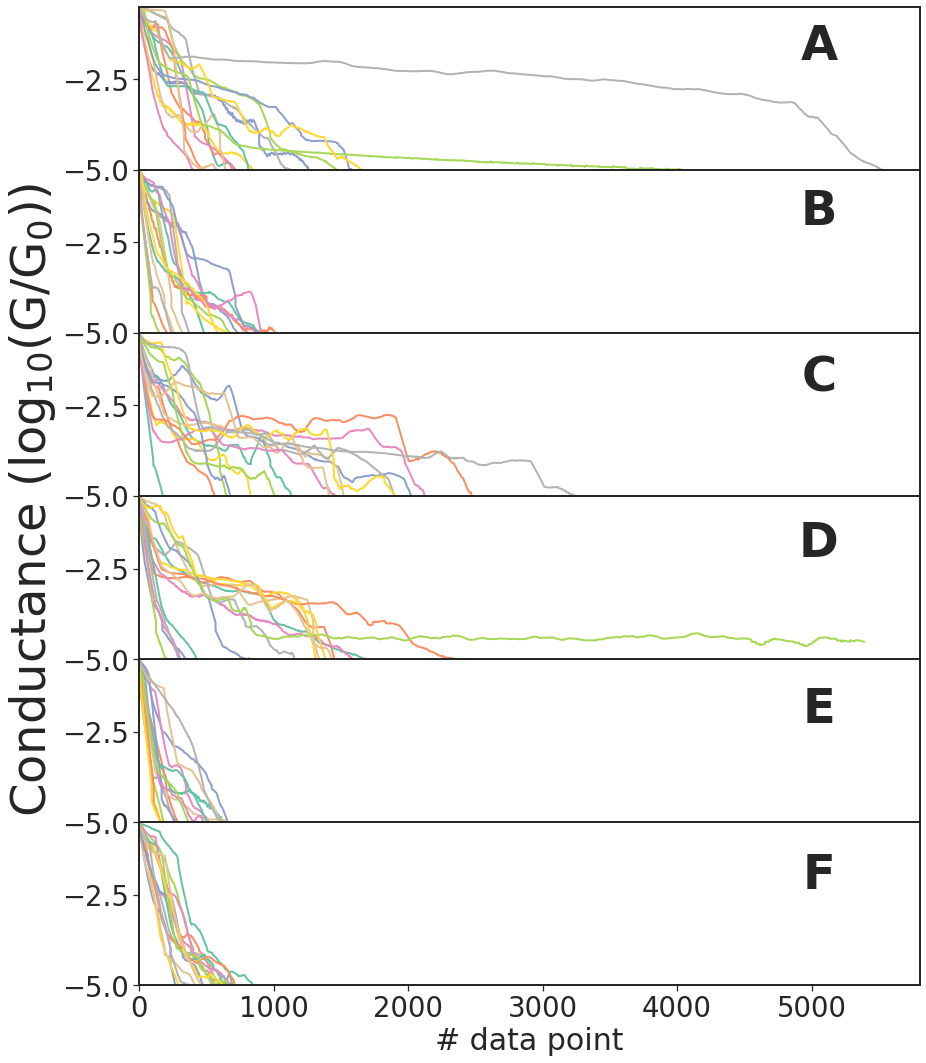

In [48]:
import matplotlib.cm as cmx
import matplotlib
cm_blues = plt.get_cmap("Blues")
cm_reds = plt.get_cmap("Reds")

bins_2d = 64
x, y = np.meshgrid(np.arange(0, bins_2d), np.arange(0, bins_2d))
fig, axes = plt.subplots(len(models), 1, figsize=(14, 18), sharex=True, sharey=True)
for idx, (ax, label_set) in enumerate(zip(axes, predicted_labels)):
    # cNorm = matplotlib.colors.Normalize(vmin=np.min(hist_2d), vmax=np.max(hist_2d)*.1)
    # scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm_blues)
    # hist_2d = generate_2dhistograms(fullwindow_molecular[label_set == 1], bins_2d=bins_2d, hist2d_length=hist2d_length)
    # hist_2d[hist_2d < 256] = 0
    # ax[0].scatter(x, y, s=hist_2d/10, c=scalarMap.to_rgba(hist_2d.ravel()), zorder=5, alpha=.5)
    
    # hist_2d = generate_2dhistograms(fullwindow_blanks, bins_2d=bins_2d, hist2d_length=hist2d_length)
    # hist_2d[hist_2d < 256] = 0
    # cNorm = matplotlib.colors.Normalize(vmin=np.min(hist_2d), vmax=np.max(hist_2d)*.1)
    # scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm_reds)
    # ax[0].scatter(x, y, s=hist_2d/10, c=scalarMap.to_rgba(hist_2d.ravel()), zorder=2)

    util_functions.plot_individual_traces(p_molecular[label_set == 1], ax, size=16, rng=rng, lw=2)
    fig.text(0.8, .85 - idx*.128, ALPHABET[idx], weight="bold", size=FONTSIZE, va="center", ha="center")

plt.subplots_adjust(hspace=0.0)
plt.xlim(-4)
plt.ylim(pre_info.plot_low, pre_info.plot_high)
axes[-1].set_xlabel("# data point")
fig.text(0.02, 0.5, CONDUCTANCE_LABEL, ha="center", va="center", rotation="vertical", fontsize=FONTSIZE)
plt.savefig("predicted_tunneling_visualized.pdf")
plt.show()

In [13]:
longest = 0
for t in p_molecular:
    if len(t) > longest:
        longest = len(t)
print(longest)

4857


In [14]:
from sklearn.manifold import TSNE

# 4857 is the longest worked trace
mea_28x28 = np.array([np.histogram2d(trace, np.arange(len(trace)), bins=28, range=[[pre_info.low, pre_info.high], [0, 4857]])[0].ravel() for trace in p_molecular])

tsne = TSNE(n_components=3, metric="cosine")
tsne_trans = tsne.fit_transform(mea_28x28)

/home/williamb/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/williamb/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/williamb/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


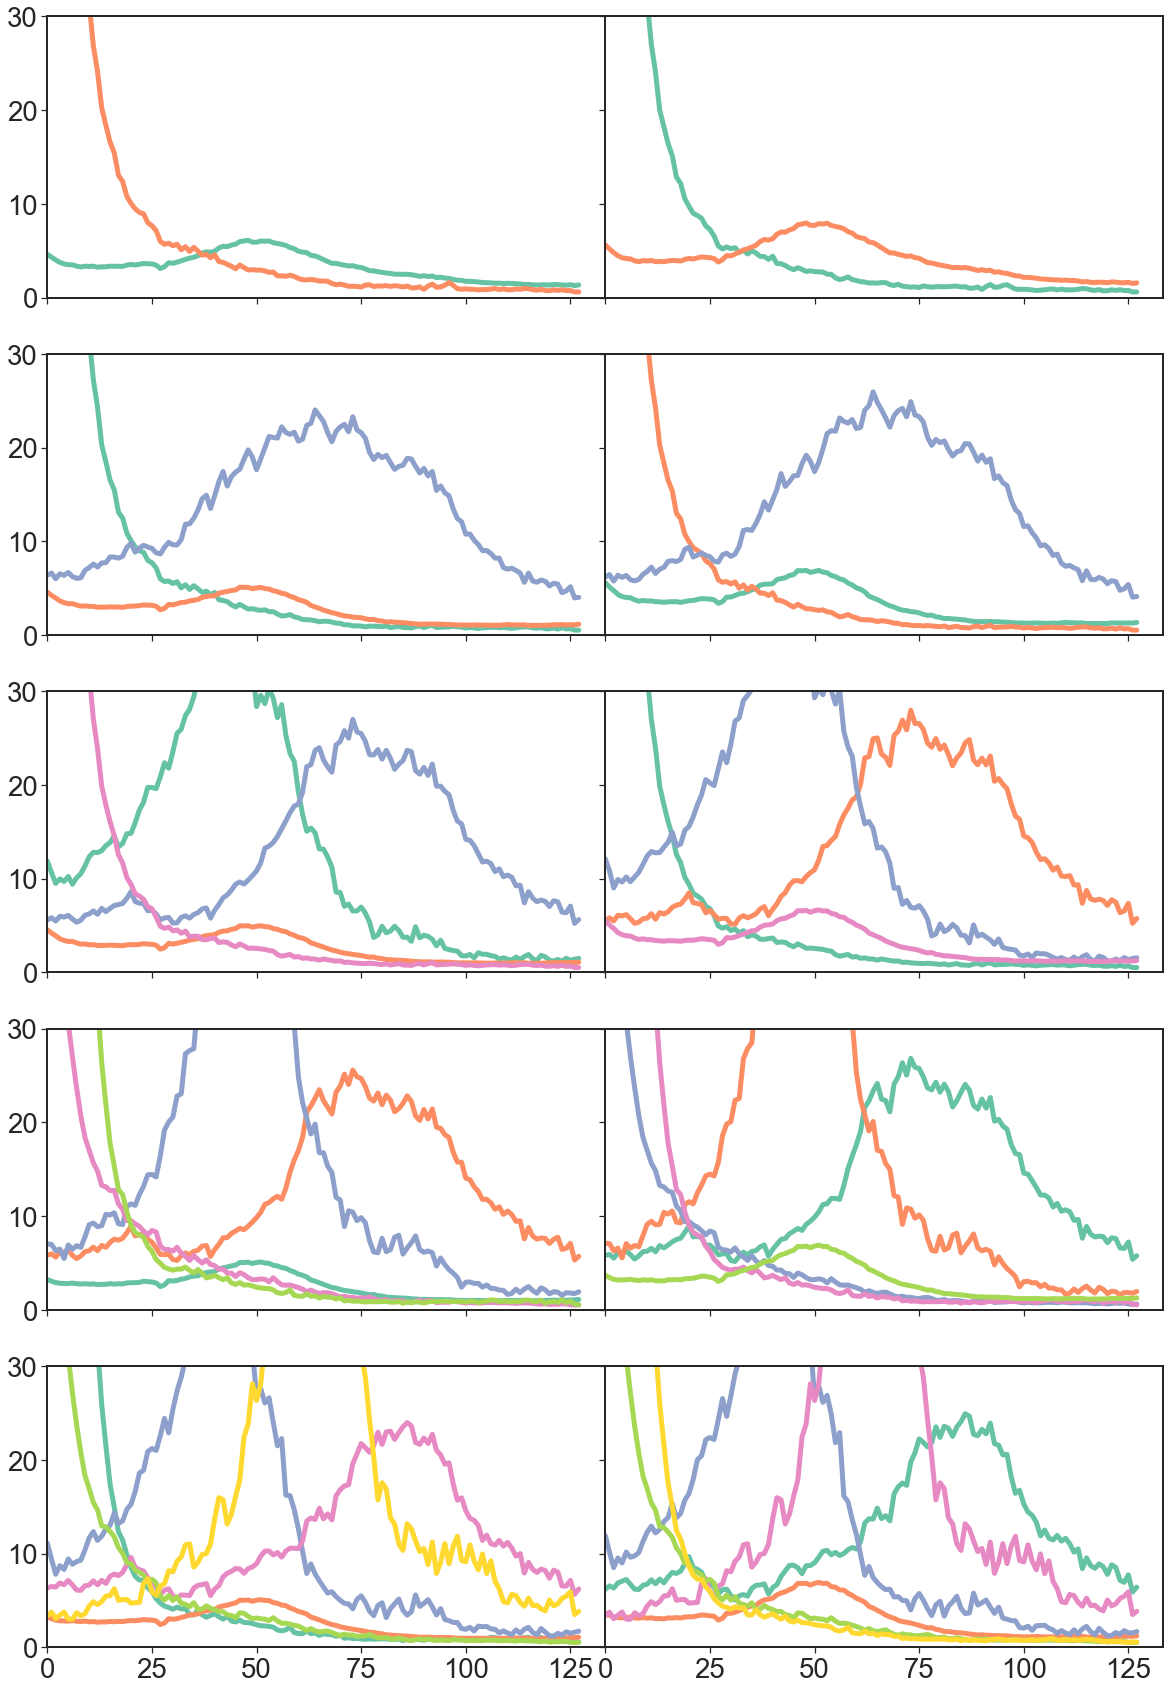

In [25]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

n_clusters = 6
subset = 1
fig, axes = plt.subplots(n_clusters - 2 + 1, 2, sharex=True, sharey=True, figsize=(20, 30))
fig.subplots_adjust(wspace=0.0)

for idx, i in enumerate(range(2, n_clusters + 1)):
    # cluster = SpectralClustering(
    #     n_clusters=i, affinity="precomputed", random_state=RNG_STATE
    # )
    # cluster = GaussianMixture(n_components=i)
    cluster = KMeans(n_clusters=i)
    # corr = np.corrcoef(mea_28x28)*.5 + .5
    full_cluster_labels = cluster.fit_predict(hist_molecular)
    # corr = np.corrcoef(mea_28x28[used_labels == -1])*.5 + .5
    subset_cluster_labels = cluster.fit_predict(hist_molecular[used_labels == -1])
    # full_cluster_labels = spectral_wenjing.fit_predict(np.corrcoef(hist_molecular)*.5 + 0.5)
    # subset_cluster_labels = spectral_wenjing.fit_predict(np.corrcoef(hist_molecular[used_labels == -1])*.5 + .5)

    for label in np.unique(full_cluster_labels):
        f = hist_molecular[::subset][full_cluster_labels == label]
        axes[idx, 0].plot(
            f.sum(axis=0)/len(f)
        )
        p = hist_molecular[::subset][used_labels == -1][subset_cluster_labels == label]
        axes[idx, 1].plot(
            p.sum(axis=0)/len(p)
        )

axes[0, 0].set_ylim(0, 30)
axes[0, 0].set_xlim(0)
plt.show()

Amount predicted molecular: 1925
Amount predicted tunneling: 8882


100%|██████████| 1558/1558 [00:00<00:00, 7549.82it/s]


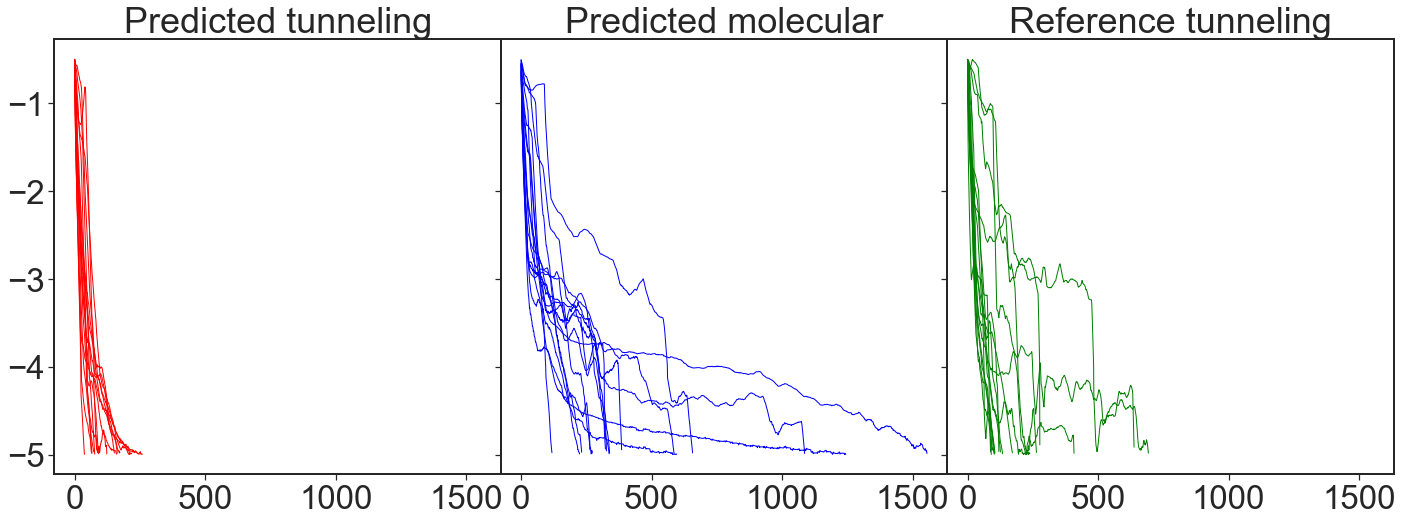

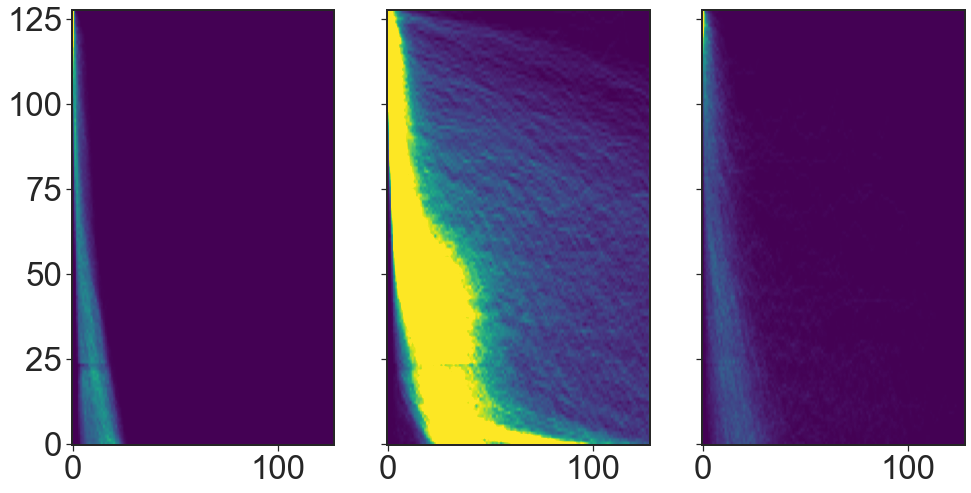

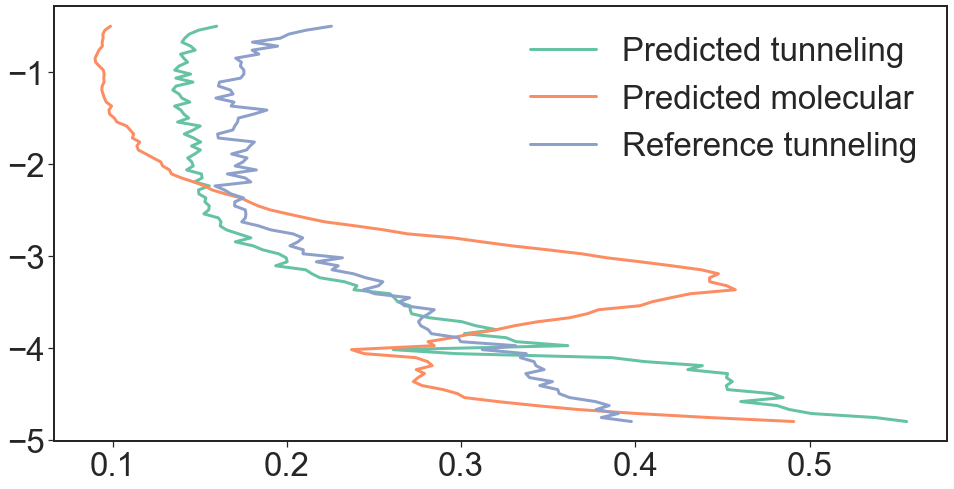

In [74]:
def generate_highres2d(traces, **kwargs):
    highres = []
    for t in tqdm(traces):
        H, *_ = np.histogram2d(t, np.arange(len(t)), **kwargs)
        highres.append(H)
    return np.array(highres)

def generate_1d(traces, **kwargs):
    hist = []
    for t in tqdm(traces):
        H, _ = np.histogram(t, density=True, **kwargs)
        hist.append(H)
    return np.array(hist)


m = p_molecular[used_labels == 1]
p = p_molecular[used_labels == -1]
print(f"Amount predicted molecular: {len(m)}")
print(f"Amount predicted tunneling: {len(p)}")
# fig, ax = plt.subplots()
# ax.plot(hist_molecular[used_labels == 1].sum(axis=0))
# ax.plot(hist_molecular[used_labels == -1].sum(axis=0))
# ax.plot(hist_blanks.sum(axis=0), label="Reference tunneling")
# plt.legend(frameon=False)

fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(24, 8))
fig.subplots_adjust(wspace=0)
for i in range(16):
    i += 32*3
    ax[0].plot(m[i], c="r", linewidth=1)
    ax[0].set_title("Predicted tunneling")
    
    ax[1].plot(p[i], c="b", linewidth=1)
    ax[1].set_title("Predicted molecular")

    ax[2].plot(p_blanks[i], c="g", linewidth=1)
    ax[2].set_title("Reference tunneling")


fig, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16, 8))
vmax = 512
plot_range = (-4.8, -.5)
# plot_range = (LOW, HIGH)
plot_bins = 100
highres_mol = generate_highres2d(fullwindow_molecular, bins=(128, 128), range=[[*plot_range], [0, 1024]])
full1d_mol = generate_1d(fullwindow_molecular, bins=plot_bins, range=plot_range)
highres_tun = generate_highres2d(fullwindow_blanks, bins=(128, 128), range=[[*plot_range], [0, 1024]])
full1d_tun = generate_1d(fullwindow_blanks, bins=plot_bins, range=plot_range)

ax[0].imshow(
    highres_mol[used_labels == 1].sum(axis=0), cmap="viridis", aspect="auto", origin="lower", vmin=0, vmax=vmax,
)
ax[1].imshow(
    highres_mol[used_labels == -1].sum(axis=0), cmap="viridis", aspect="auto", origin="lower", vmin=0, vmax=vmax,
)
ax[2].imshow(
    highres_tun.sum(axis=0), cmap="viridis", aspect="auto", origin="lower", vmin=0, vmax=vmax,
)

fig, ax = plt.subplots(figsize=(16, 8))
x = np.linspace(*plot_range, plot_bins)
ax.plot(full1d_mol[used_labels == 1].sum(axis=0)/len(full1d_mol[used_labels == 1]), x, label="Predicted tunneling")
ax.plot(full1d_mol[used_labels == -1].sum(axis=0)/len(full1d_mol[used_labels == -1]), x, label="Predicted molecular")
ax.plot(full1d_tun.sum(axis=0)/len(full1d_tun), x, label="Reference tunneling")

plt.legend(frameon=False)
plt.show()

In [229]:
def calc_stats(traces):
    stats = []
    for t in traces:
        mean = np.mean(t)
        median = np.median(t)
        std = np.std(t)
        length = len(t)

        x = np.arange(len(t))
        m = np.polyfit(x, t, deg=1)
        rmsd = np.mean((t - x*m[0] + m[1])**2)

        stats.append([mean, median, std, length, rmsd])
    return np.array(stats)

selected_model = models[0]
pred_labels = selected_model.predict(scaler.transform(features_molecular))

pred_tunneling = molecular_traces[pred_labels == 1]
true_tunneling = blank_traces

stats_pred, stats_true = calc_stats(pred_tunneling), calc_stats(true_tunneling)

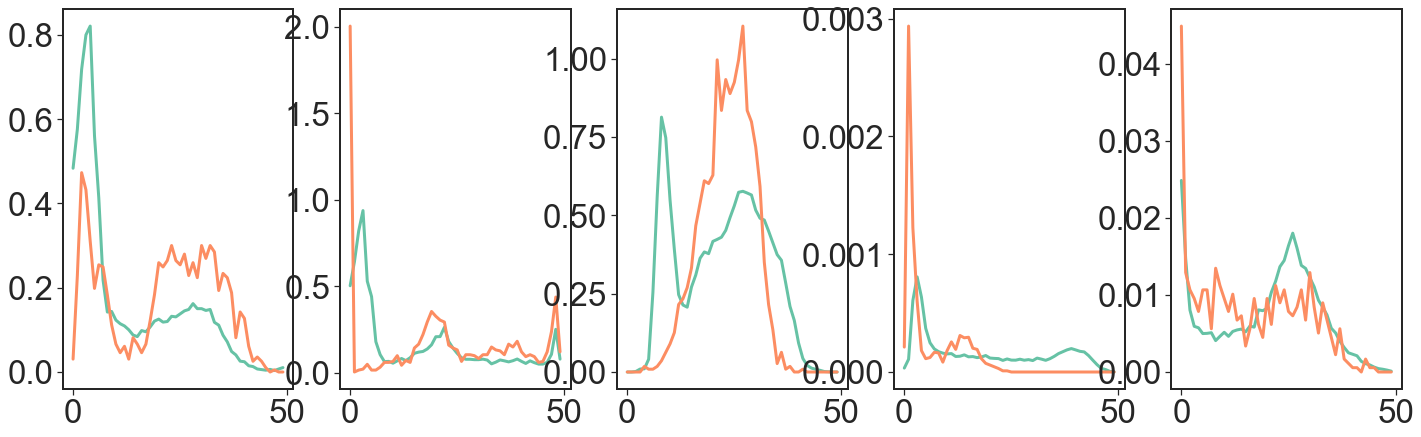

In [230]:
fig, ax = plt.subplots(1, 5, figsize=(24, 7))
bins = 50
ax[0].plot(np.histogram(stats_pred[:, 0], bins=bins, range=(-6, 0), density=True)[0])
ax[0].plot(np.histogram(stats_true[:, 0], bins=bins, range=(-6, 0), density=True)[0])

ax[1].plot(np.histogram(stats_pred[:, 1], bins=bins, range=(-6, 0), density=True)[0])
ax[1].plot(np.histogram(stats_true[:, 1], bins=bins, range=(-6, 0), density=True)[0])

ax[2].plot(np.histogram(stats_pred[:, 2], bins=bins, range=(0.1, 3.5), density=True)[0])
ax[2].plot(np.histogram(stats_true[:, 2], bins=bins, range=(0.1, 3.5), density=True)[0])

ax[3].plot(np.histogram(stats_pred[:, 3], bins=bins, range=(0, 6200), density=True)[0])
ax[3].plot(np.histogram(stats_true[:, 3], bins=bins, range=(0, 6200), density=True)[0])

ax[4].plot(np.histogram(stats_pred[:, 4], bins=bins, range=(10, 150), density=True)[0])
ax[4].plot(np.histogram(stats_true[:, 4], bins=bins, range=(10, 150), density=True)[0])

plt.show()

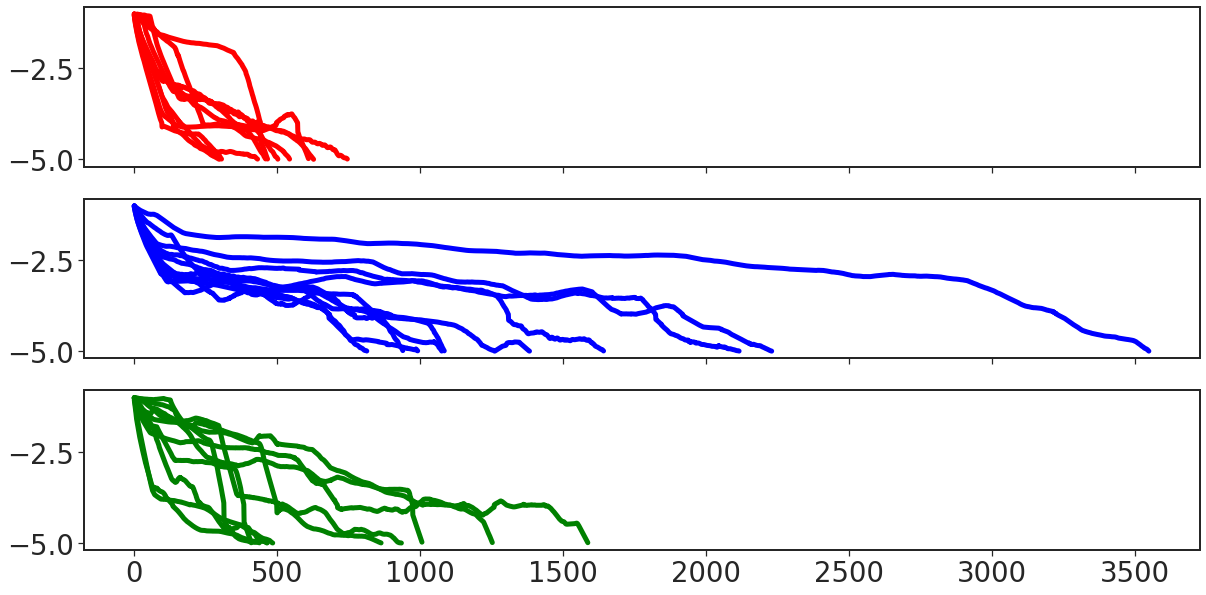

In [24]:
pre_mol = fullwindow_molecular[predicted_labels[1] == 1]
pre_tun = fullwindow_molecular[predicted_labels[1] == -1]

fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(20, 10))
for t1, t2, t3 in zip(
    pre_mol[rng.integers(0, high=len(pre_mol), size=10)],
    pre_tun[rng.integers(0, high=len(pre_tun), size=10)],
    fullwindow_blanks[rng.integers(0, high=len(fullwindow_blanks), size=10)],
):
    ax[0].plot(t1, c="r")
    ax[1].plot(t2, c="b")
    ax[2].plot(t3, c="g")
plt.show()